This computation was originally done in Google Colab, and therefore our R was interpereted through python to allow us to mount a drive for storage of data and packages.

# Replicating Young et al.

https://doi.org/10.1126/science.aat1699

All analysis code for *Single cell transcriptomes from human kidneys reveal the cellular identity of renal tumors* is available on [GitHub](https://github.com/constantAmateur/scKidneyTumors). Our replication here is adaped as closely as possible from the original analysis.

In [ ]:
%reload_ext rpy2.ipython
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%R
lib_loc <- "/content/drive/MyDrive/r-lib"

library(Matrix, lib = lib_loc)
library(Seurat, lib = lib_loc)
library(varhandle, lib = lib_loc)
library(harmony, lib = lib_loc)
library(stringr, lib = lib_loc)
library(sva, lib = lib_loc)

In [ ]:
%%R
library(BiocManager, lib = lib_loc)
install('genefilter')
install('sva')

In [ ]:
%%R
library('sva')

The data here can be downloaded from..., as the MTX and TSV files described below.

In [ ]:
%%R
dataset <- readMM("/content/drive/Shareddrives/Research - Stephen/Young/Young Data/matrix.mtx.gz")
genes <- read.table("/content/drive/Shareddrives/Research - Stephen/Young/Young Data/features.tsv.gz", sep = "\t" )
genes_ids <- genes$V2
cells <- read.table("/content/drive/Shareddrives/Research - Stephen/Young/Young Data/barcodes.tsv.gz", sep = "\t", header = TRUE)
cell_ids <- cells$Barcode

This step reformats the feature names to remove the concatinated ensembl id:

In [ ]:
%%R
splitted <- str_split(genes_ids, '_', simplify = TRUE)
genes_ids <- splitted[,1]
genes_ids <- factor(genes_ids)
rownames(dataset) <- genes_ids
colnames(dataset) <- cell_ids

This file contains the metadata for each cell from the original analysis. It can be downloaded as a suplement to the original paper, linked [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6104812/bin/NIHMS78997-supplement-Supplementary_tables.xlsx). The data from the sheet entitled 'Cell Manifest' was saved as a csv and loaded here.

In [ ]:
%%R
annotations <- read.csv("/content/drive/Shareddrives/Research - Stephen/Organized Files/Datasets/Young/Data/YoungMetadata.csv")
colnames(annotations) <- annotations[1,]
annotations <- annotations[2:nrow(annotations),]

We performed quality control by using only cells marked as normal or normal immune in the meta data.

In [ ]:
%%R
dataset <- dataset[,annotations$ClusterID %in% unique(grep('N', annotations$ClusterID, value = TRUE))]

annotations <- annotations[annotations$ClusterID %in% unique(grep('N', annotations$ClusterID, value = TRUE)),]

After this, we added the metadata included in the suplement to the cells.

In [ ]:
%%R
sobj <- CreateSeuratObject(dataset)
sobj[['percent.mt']] <- annotations$MTfrac
sobj[['source']] <- annotations$Source
sobj[['SangerID']] <- annotations$SangerID
sobj[['ClusterID']] <- annotations$ClusterID

The folowing normalization, batch correction, scaling, and identification of variable features was taken with little modification from the original analysis code.

In [ ]:
%%R
sobj <- NormalizeData(sobj,scale.factor=1e4)
tmp <- sobj@assays$RNA@data
gCnts <- rowSums(tmp>0)
tmp <- as.matrix(tmp[gCnts>3,])
w <- which(tmp == 0)

tmp <- ComBat(dat=tmp, batch=sobj$source)

tmp[w]=0

scaleFac = mean(colSums(exp(sobj@assays$RNA@data)-1))
    #Need to find the correction factor for each cell
    pb = txtProgressBar(min=0,max=ncol(tmp),style=3)
    normFacts=list()
    for(i in seq_len(ncol(tmp))){
      normFacts[[i]] = uniroot(function(e) (sum(exp(tmp[,i]*e)-1)-scaleFac),c(0,10))
      setTxtProgressBar(pb,i)
    }
    close(pb)
    tmp = t(t(tmp)*sapply(normFacts,function(e) e$root))

    w <- which(tmp>0,arr.ind=TRUE)
tmp <- sparseMatrix(i=which(gCnts>3)[w[,1]],j=w[,2],x=tmp[w],dims=dim(sobj@assays$RNA@data),dimnames=list(rownames(sobj@assays$RNA@data),colnames(sobj@assays$RNA@data)))

sobj[['RNA']]@data <- tmp

sobj <- FindVariableFeatures(sobj, selection.method = "mvp", mean.cutoff =  c(0.0125, 3), dispersion.cutoff = c(0.5, Inf))

The next step follows procedure detailed in the original analysis in which independently identified biomarkers are forced to be included in the variable features for the downstream analysis.

In [ ]:
%%R
markergenes <- read.csv("/content/drive/Shareddrives/Research - Stephen/Organized Files/Datasets/Young/Data/YoungMarkerGenes.csv")
markergenes[2:nrow(markergenes),1] -> markergenes

m <- list()
    #Find the gene name
   for( i in 1:length(markergenes)){
     m[[i]] <- grep(markergenes[i], rownames(sobj@assays$RNA@data))
   }
m <- unlist(m)

extras <- rownames(sobj@assays$RNA@data)[m[!is.na(m)]]
extras <- extras[rowSums(sobj@assays$RNA@data[extras,])>0]
    #Force them to be in the variable genes
sobj@assays$RNA@var.features = unique(c(extras,sobj@assays$RNA@var.features))

The following scaling and reductions are taken from the original analysis code.

In [ ]:
%%R
sobj <- ScaleData(sobj)
sobj <- RunPCA(sobj,weight.by.var=FALSE,do.print=FALSE,maxit=1000)
sobj<- RunTSNE(sobj,dims = 1:30,do.fast=TRUE,check_duplicates=FALSE, reduction = 'pca')

The map below is a sanity check showing that cells originally annotated as parts of the same clusters largely grouped together in our replication as well.

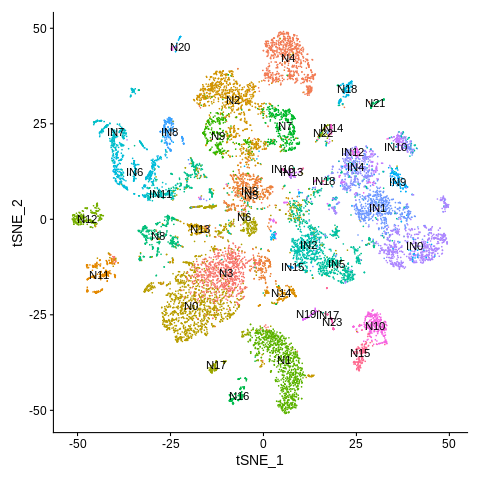

In [ ]:
%%R
Idents(sobj) <- sobj$ClusterID
DimPlot(sobj, label = TRUE) + NoLegend()

Now, we assigned the labels detailed in the cluster manifest to their clusters. These assignments can be found in the same excel file linked earlier in the sheet named 'Cluster Info'.

In [ ]:
%%R
annotations <- c('Nephron_epithelium', 'Descending_vasa_recta', 'Nephron_epithelium', 'Glomerular_epithelium_and_podocytes', 'Distal_tubule_and_collecting_duct_principle_cells', 'Ascending_vasa_recta', 'Proximal_tubule_convoluted_tubular', 'Loop_of_Henle', 'Nephron_epithelium', 'Collecting_duct_type_A', 'Proximal_tubule_convoluted_and_straight', 'Proximal_tubule_convoluted_and_straight','Nephron_epithelium', 'Ascending_vasa_recta', 'Glomerular_endothelium', 'Collecting_duct_type_B', 'Fibroblast_ureter', 'Loop_of_Henle', 'Junk', 'Private', 'Private', 'Neutrophil', 'MNP', 'MNP', 'Mesangial', 'Pelvic_epithelium', 'NKT', 'Mast', 'MNP', 'NKT', 'Th', 'NK', 'CD8T', 'B', 'Urothelium_superficial', 'Private', 'Urothelium_intermediate_and_basal', 'NK_proliferating', 'Plasmacytoid', 'Urothelium_superficial', 'Junk', 'Junk', 'Urothelium')
names(annotations) <- levels(sobj)
sobj <- RenameIdents(sobj, annotations)

Below is the same TSNE as before, except with the cell types labeled.

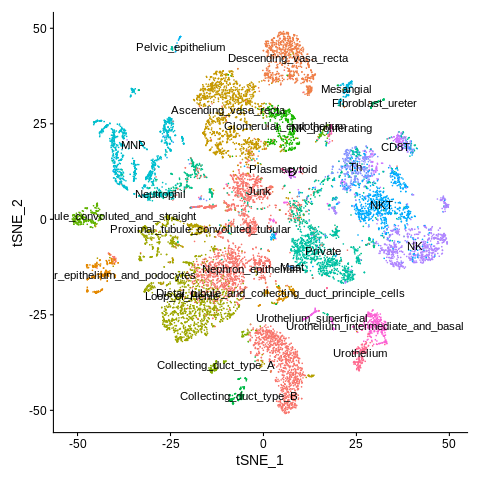

In [ ]:
%%R
DimPlot(sobj, label = TRUE) + NoLegend()

In [ ]:
%%R
save(sobj, file  = "/content/drive/Shareddrives/Research - Stephen/Organized Files/Datasets/Young/Seurat Object/youngcolab2")

This was the object that was included in our next analysis steps. Below, however, is an evaluation of our results as compared to the UMAP published in the original paper.

In [ ]:
%%R
library(Seurat, lib = lib_loc)

In [ ]:
%%R
load("/content/drive/Shareddrives/Research - Stephen/Organized Files/Datasets/Young/Seurat Object/youngcolab")

In [ ]:
%%R
sobj1 <- subset(sobj, subset = ClusterID %in% c('N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10','N11','N12','N13','N14','N15','N16','N17','N18','N19','N20','N21','N22','N23'))

In [ ]:
%%R
levels(sobj1)

 [1] "Nephron_epithelium"                               
 [2] "Descending_vasa_recta"                            
 [3] "Glomerular_epithelium_and_podocytes"              
 [4] "Distal_tubule_and_collecting_duct_principle_cells"
 [5] "Ascending_vasa_recta"                             
 [6] "Proximal_tubule_convoluted_tubular"               
 [7] "Loop_of_Henle"                                    
 [8] "Collecting_duct_type_A"                           
 [9] "Proximal_tubule_convoluted_and_straight"          
[10] "Glomerular_endothelium"                           
[11] "Collecting_duct_type_B"                           
[12] "Fibroblast_ureter"                                
[13] "Mesangial"                                        
[14] "Pelvic_epithelium"                                
[15] "Urothelium_superficial"                           
[16] "Urothelium_intermediate_and_basal"                
[17] "Urothelium"                                       


In [ ]:
%%R
nn <- c('NEPH', 'DV','G','D','AV','PT1','H','C1','PT2','GE','C2','F','MES','P','U1','U2','U3')

In [ ]:
%%R
names(nn) <- levels(sobj1)
sobj1 <- RenameIdents(sobj1, nn)

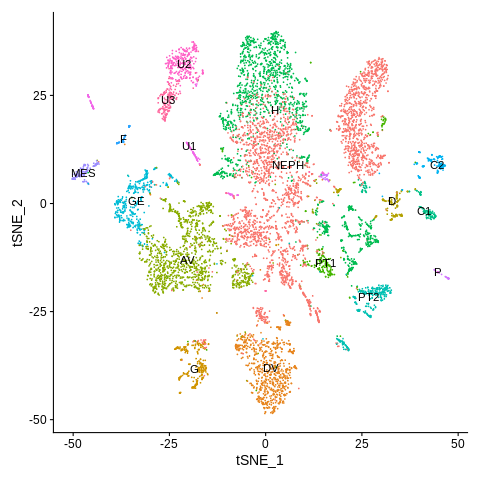

In [ ]:
%%R
sobj1 <- RunTSNE(sobj1, dims = 1:30)
DimPlot(sobj1, label = TRUE) + NoLegend()

In [ ]:
%%R
plot <- DimPlot(sobj1, label = TRUE) + NoLegend()
saveRDS(plot, file = 'plot.RDS')